# Computational Appendix: Whole-Proteome ESM-2 Embeddings for Foodborne Bacterial Surveillance

**Author:** Jay Gutierrez

This notebook serves as the computational appendix for the manuscript *"Whole-Proteome ESM-2 Embeddings Recover Taxonomy and Enable Geometry-Aware Triage of Foodborne Bacterial Genomes."* It reproduces all manuscript figures and tables from pre-computed artifacts, ensuring reproducibility for reviewers and collaborators.

---

## Table of Contents

1. [Setup & Configuration](#1-setup--configuration)
2. [Data Loading & Validation](#2-data-loading--validation)
3. [Data Overview & Quality Control](#3-data-overview--quality-control)
4. [Dimensionality Reduction](#4-dimensionality-reduction)
5. [Clustering & Stability](#5-clustering--stability)
6. [Species Centroid Analysis](#6-species-centroid-analysis)
7. [Homophily Analysis](#7-homophily-analysis)
8. [Pathogenicity Separation & Phylogenetic Entanglement](#8-pathogenicity-separation--phylogenetic-entanglement)
9. [Outlier Analysis](#9-outlier-analysis)
10. [Within-Genus Stress Tests](#10-within-genus-stress-tests)
11. [Confidence Calibration & Risk-Coverage](#11-confidence-calibration--risk-coverage)
12. [Manuscript-Aligned Interpretation](#12-manuscript-aligned-interpretation)
13. [Artifact Verification](#13-artifact-verification)

---

## 1. Setup & Configuration

This section configures portable paths (relative to repository root) and imports required libraries.

In [1]:
# Configuration
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Detect repository root (works from notebooks/ directory)
NOTEBOOK_DIR = Path.cwd()
if NOTEBOOK_DIR.name == 'notebooks':
    REPO_ROOT = NOTEBOOK_DIR.parent
else:
    REPO_ROOT = NOTEBOOK_DIR

# Portable paths (relative to repo root)
ANALYSIS_DIR = REPO_ROOT / 'foodguard' / 'analysis'
LOGS_DIR = REPO_ROOT / 'foodguard' / 'logs'
DATA_DIR = REPO_ROOT / 'data' / 'genome_statistics'

# Key artifact paths
ENRICHED_PARQUET = ANALYSIS_DIR / 'genome_embeddings_enriched.parquet'
DIM_CACHE = ANALYSIS_DIR / 'dim_reduction_cache.npz'

# Manuscript mode: ensures reproducibility
MANUSCRIPT_MODE = True
RANDOM_SEED = 42

print(f"Repository root: {REPO_ROOT}")
print(f"Analysis directory: {ANALYSIS_DIR}")
print(f"Manuscript mode: {MANUSCRIPT_MODE}")

Repository root: /Users/jaygut/Documents/Side_Projects/Bacformer
Analysis directory: /Users/jaygut/Documents/Side_Projects/Bacformer/foodguard/analysis
Manuscript mode: True


In [2]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from IPython.display import display, Markdown, HTML

# Set seeds for reproducibility
np.random.seed(RANDOM_SEED)

# Plot styling
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 150
plt.rcParams['font.size'] = 10

print("Libraries loaded successfully.")

Libraries loaded successfully.


---

## 2. Data Loading & Validation

We load the pre-computed enriched genome embeddings dataset, which contains:
- 21,657 bacterial genomes from 9 food safety-relevant taxa
- 480-dimensional ESM-2 mean-pooled embeddings
- Pre-computed PCA, UMAP, and t-SNE coordinates
- Cluster assignments, homophily scores, and outlier flags

### Key Manuscript Framing

> **Labels are species/pathotype-derived priors, not isolate-level virulence truth.**
> The pathogenicity label used throughout this analysis is derived from species/pathotype assignments (e.g., *Salmonella enterica* = pathogenic, *Bacillus subtilis* = non-pathogenic). This label is suitable for studying embedding geometry and retrieval consistency, but cannot resolve within-species virulence variation.

> **"Context-free" refers to genome-level representation.**
> ESM-2 is contextual *within* each protein sequence (via self-attention), but our mean-pooling approach discards gene order, co-localization, and operon-scale context at the genome level.

In [3]:
# Load enriched genome embeddings
print(f"Loading data from: {ENRICHED_PARQUET}")

if ENRICHED_PARQUET.exists():
    df = pd.read_parquet(ENRICHED_PARQUET)
    print(f"Loaded {len(df):,} genomes with {len(df.columns)} columns")
else:
    raise FileNotFoundError(f"Enriched parquet not found: {ENRICHED_PARQUET}")

# Display column overview
print(f"\nColumns: {list(df.columns)}")

Loading data from: /Users/jaygut/Documents/Side_Projects/Bacformer/foodguard/analysis/genome_embeddings_enriched.parquet
Loaded 21,657 genomes with 20 columns

Columns: ['genome_id', 'species', 'pathogenicity', 'pathogenicity_label', 'proteins', 'taxon_id', 'pca_1', 'pca_2', 'umap_1', 'umap_2', 'cluster', 'pathogenicity_homophily', 'species_homophily', 'tsne_1', 'tsne_2', 'k_neighbor_distance', 'silhouette_pathogenicity', 'is_distance_outlier', 'is_outlier_strict', 'is_outlier']


In [4]:
# Load dimensionality reduction cache
if DIM_CACHE.exists():
    dim_cache = np.load(DIM_CACHE)
    print(f"Loaded dim reduction cache with keys: {list(dim_cache.keys())}")
    
    # Extract explained variance for PCA
    if 'explained_variance' in dim_cache:
        explained_variance = dim_cache['explained_variance']
        cumulative_variance = np.cumsum(explained_variance)
        print(f"\nPCA explained variance:")
        print(f"  PC1: {explained_variance[0]*100:.2f}%")
        print(f"  PC2: {explained_variance[1]*100:.2f}%")
        print(f"  PC3: {explained_variance[2]*100:.2f}%")
        print(f"  Cumulative (3 PCs): {cumulative_variance[2]*100:.2f}%")
else:
    print(f"Warning: Dim reduction cache not found at {DIM_CACHE}")
    dim_cache = None

Loaded dim reduction cache with keys: ['pca_result', 'umap_result', 'tsne_result', 'explained_variance']

PCA explained variance:
  PC1: 76.56%
  PC2: 10.95%
  PC3: 6.83%
  Cumulative (3 PCs): 94.33%


In [5]:
# Dataset summary
display(Markdown("### Dataset Summary"))

summary_data = {
    'Metric': ['Total genomes', 'Species count', 'Pathogenic genomes', 'Non-pathogenic genomes', 
               'Embedding dimensions', 'Cluster count (excluding noise)'],
    'Value': [
        f"{len(df):,}",
        str(df['species'].nunique()),
        f"{(df['pathogenicity_label'] == 'pathogenic').sum():,}",
        f"{(df['pathogenicity_label'] == 'non-pathogenic').sum():,}",
        "480",
        str(df[df['cluster'] >= 0]['cluster'].nunique())
    ]
}
display(pd.DataFrame(summary_data))

### Dataset Summary

,Metric,Value
0,Total genomes,"21,657"
1,Species count,9
2,Pathogenic genomes,"13,000"
3,Non-pathogenic genomes,0
4,Embedding dimensions,480
5,Cluster count (excluding noise),34


---

## 3. Data Overview & Quality Control

This section presents the class balance, species distribution, and quality control metrics.

In [6]:
# Species distribution table (matches manuscript Table 1)
display(Markdown("### Table 1: Dataset Composition by Taxon"))

species_summary = df.groupby(['species', 'pathogenicity_label']).size().reset_index(name='n')
species_summary = species_summary.sort_values('n', ascending=False)

# Format for manuscript
table_data = []
for _, row in species_summary.iterrows():
    table_data.append({
        'Taxon': row['species'].replace('_', ' '),
        'n': f"{row['n']:,}",
        'Label': row['pathogenicity_label']
    })

display(pd.DataFrame(table_data))

### Table 1: Dataset Composition by Taxon

,Taxon,n,Label
0,Salmonella enterica,"7,000",pathogenic
1,L monocytogenes,"4,500",pathogenic
2,E coli nonpathogenic,"4,312",non_pathogenic
3,B subtilis,"2,361",non_pathogenic
4,E coli O157H7,"1,500",pathogenic
5,C koseri,897,non_pathogenic
6,L innocua,449,non_pathogenic
7,E fergusonii,438,non_pathogenic
8,C freundii,200,non_pathogenic


### QC Overview

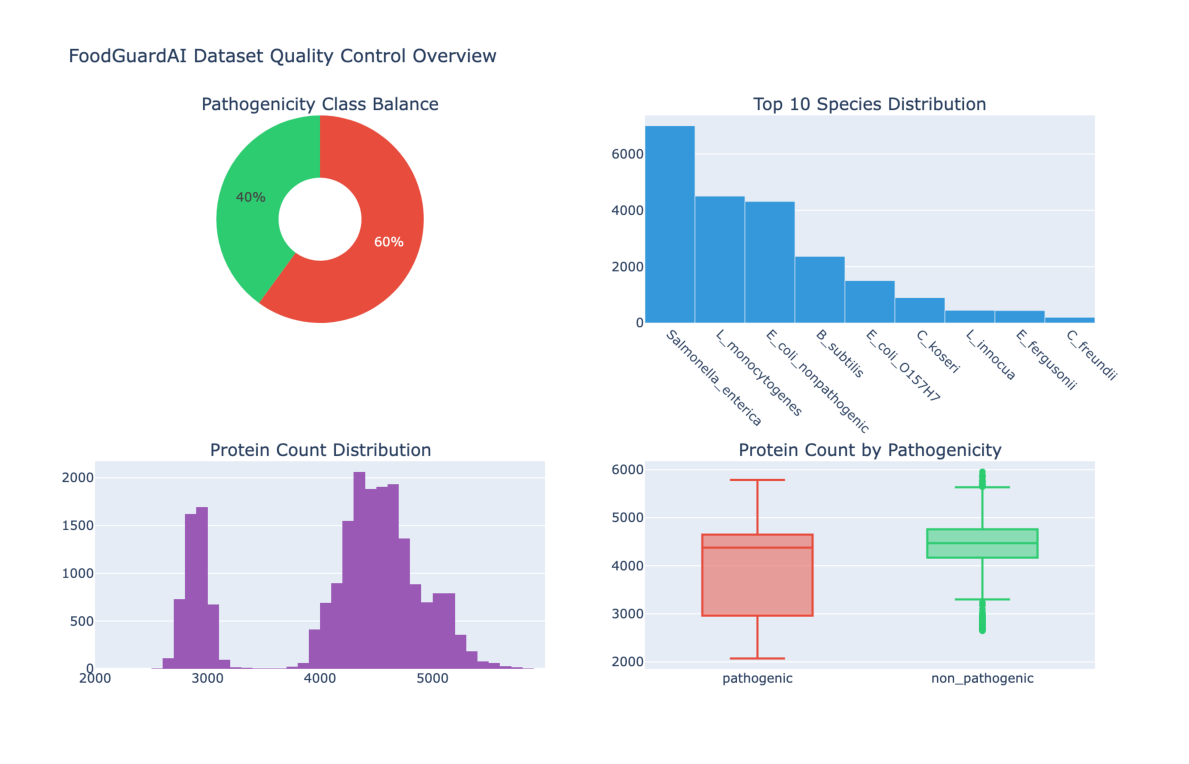

In [7]:
# Display QC overview figure
qc_fig_path = ANALYSIS_DIR / 'qc_overview.png'

if qc_fig_path.exists():
    display(Markdown("### QC Overview"))
    img = Image.open(qc_fig_path)
    plt.figure(figsize=(12, 8))
    plt.imshow(img)
    plt.axis('off')
    plt.tight_layout()
    plt.show()
else:
    print(f"QC figure not found at {qc_fig_path}")

In [8]:
# Load outlier assembly quality summary (backs manuscript Section 3.7)
outlier_qc_path = ANALYSIS_DIR / 'outlier_assembly_quality_summary.csv'

if outlier_qc_path.exists():
    display(Markdown("### Outlier Assembly Quality Comparison (Manuscript Section 3.7)"))
    outlier_qc = pd.read_csv(outlier_qc_path)
    display(outlier_qc)
    
    display(Markdown("""
    > **Interpretation:** Strict outliers tend toward larger genomes and proteomes 
    > (median genome size 5.18 Mb vs 4.78 Mb; median proteins 4,902 vs 4,403) and exhibit 
    > a heavy-tailed fragmentation profile (75th percentile contig count 231 vs 54).
    """))
else:
    print(f"Outlier QC summary not found at {outlier_qc_path}")

### Outlier Assembly Quality Comparison (Manuscript Section 3.7)

,group,n,proteins_median,proteins_q25,proteins_q75,genome_size_bp_median,genome_size_bp_q25,genome_size_bp_q75,contig_count_median,contig_count_q25,contig_count_q75,n50_length_median,n50_length_q25,n50_length_q75
0,non_strict,21405,4403.0,3984.00,4689.00,4777419.0,4040359.00,5050489.00,13.0,2.0,54.00,1048732.0,308944.00,4756748.0
1,strict_outliers,252,4901.5,4552.75,5269.75,5177489.0,4879385.75,5518017.25,7.5,3.0,230.75,4599618.0,223529.25,5042090.5



    > **Interpretation:** Strict outliers tend toward larger genomes and proteomes 
    > (median genome size 5.18 Mb vs 4.78 Mb; median proteins 4,902 vs 4,403) and exhibit 
    > a heavy-tailed fragmentation profile (75th percentile contig count 231 vs 54).
    

---

## 4. Dimensionality Reduction

The embedding space exhibits strong low-dimensional structure dominated by taxonomic signals.

### Key Findings (Manuscript Section 3.1-3.2)
- **PC1 explains 76.56%** of variance
- **3 PCs capture 94.3%** of cumulative variance
- PCA separates Firmicutes (negative PC1) from Enterobacterales (positive PC1)

### Caveats
> **PCA is a global linear model** that concentrates variance along directions best explaining the dataset under a linear assumption. Additional structure can reside in higher-order PCs and non-linear manifolds.

> **UMAP and t-SNE prioritize local neighborhood structure** and can distort global geometry. These projections should be interpreted in terms of neighborhood consistency, not absolute distances.

### Figure 2A: PCA Explained Variance

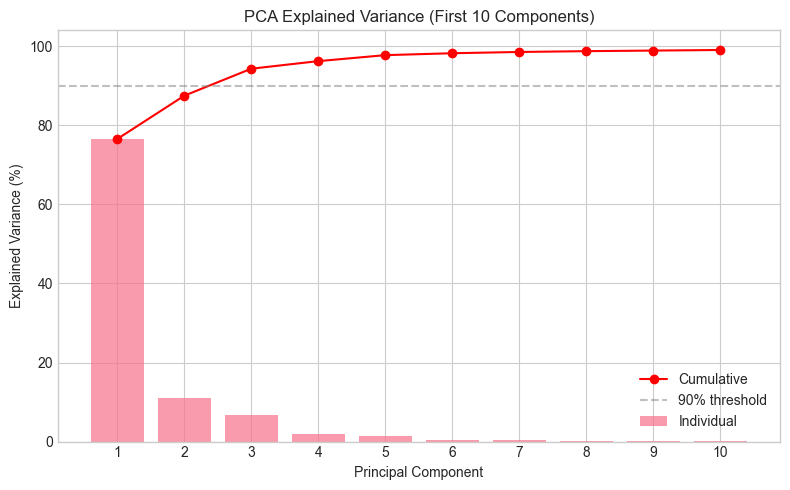


PC1: 76.56%, PC2: 10.95%, PC3: 6.83%
Cumulative (3 PCs): 94.33%


In [9]:
# Display PCA explained variance
display(Markdown("### Figure 2A: PCA Explained Variance"))

if dim_cache is not None and 'explained_variance' in dim_cache:
    ev = dim_cache['explained_variance'][:10] * 100
    cumsum = np.cumsum(ev)
    
    fig, ax = plt.subplots(figsize=(8, 5))
    x = np.arange(1, 11)
    ax.bar(x, ev, alpha=0.7, label='Individual')
    ax.plot(x, cumsum, 'ro-', label='Cumulative')
    ax.axhline(y=90, color='gray', linestyle='--', alpha=0.5, label='90% threshold')
    ax.set_xlabel('Principal Component')
    ax.set_ylabel('Explained Variance (%)')
    ax.set_title('PCA Explained Variance (First 10 Components)')
    ax.legend()
    ax.set_xticks(x)
    plt.tight_layout()
    plt.show()
    
    print(f"\nPC1: {ev[0]:.2f}%, PC2: {ev[1]:.2f}%, PC3: {ev[2]:.2f}%")
    print(f"Cumulative (3 PCs): {cumsum[2]:.2f}%")

### Figure 2: PCA Overview (Manuscript Figure)

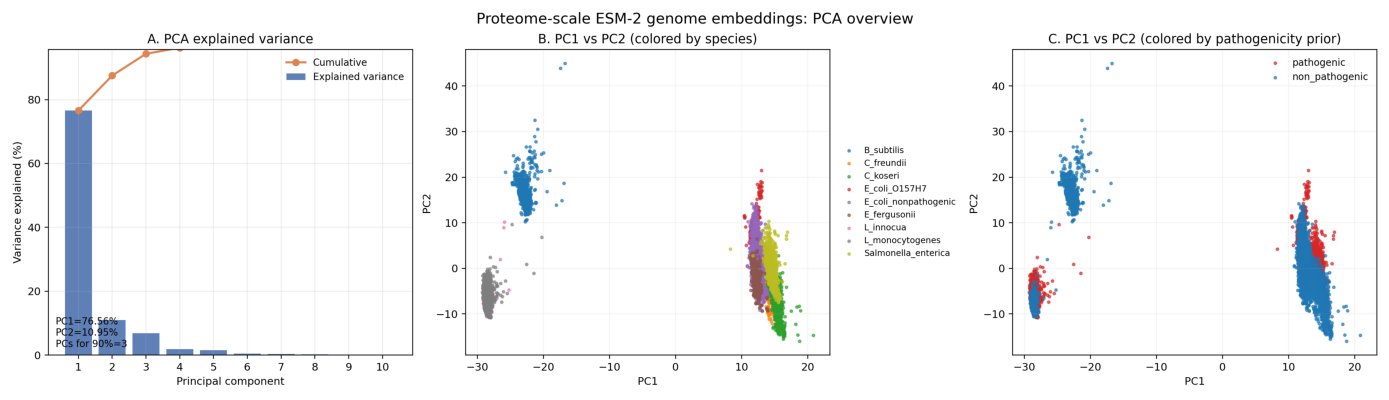

In [10]:
# Display manuscript PCA figure
pca_fig_path = ANALYSIS_DIR / 'manuscript_figure_pca_overview.png'

display(Markdown("### Figure 2: PCA Overview (Manuscript Figure)"))

if pca_fig_path.exists():
    img = Image.open(pca_fig_path)
    plt.figure(figsize=(14, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.tight_layout()
    plt.show()
else:
    print(f"PCA figure not found at {pca_fig_path}")

### Figure 3: UMAP and t-SNE Projections (Manuscript Figure)

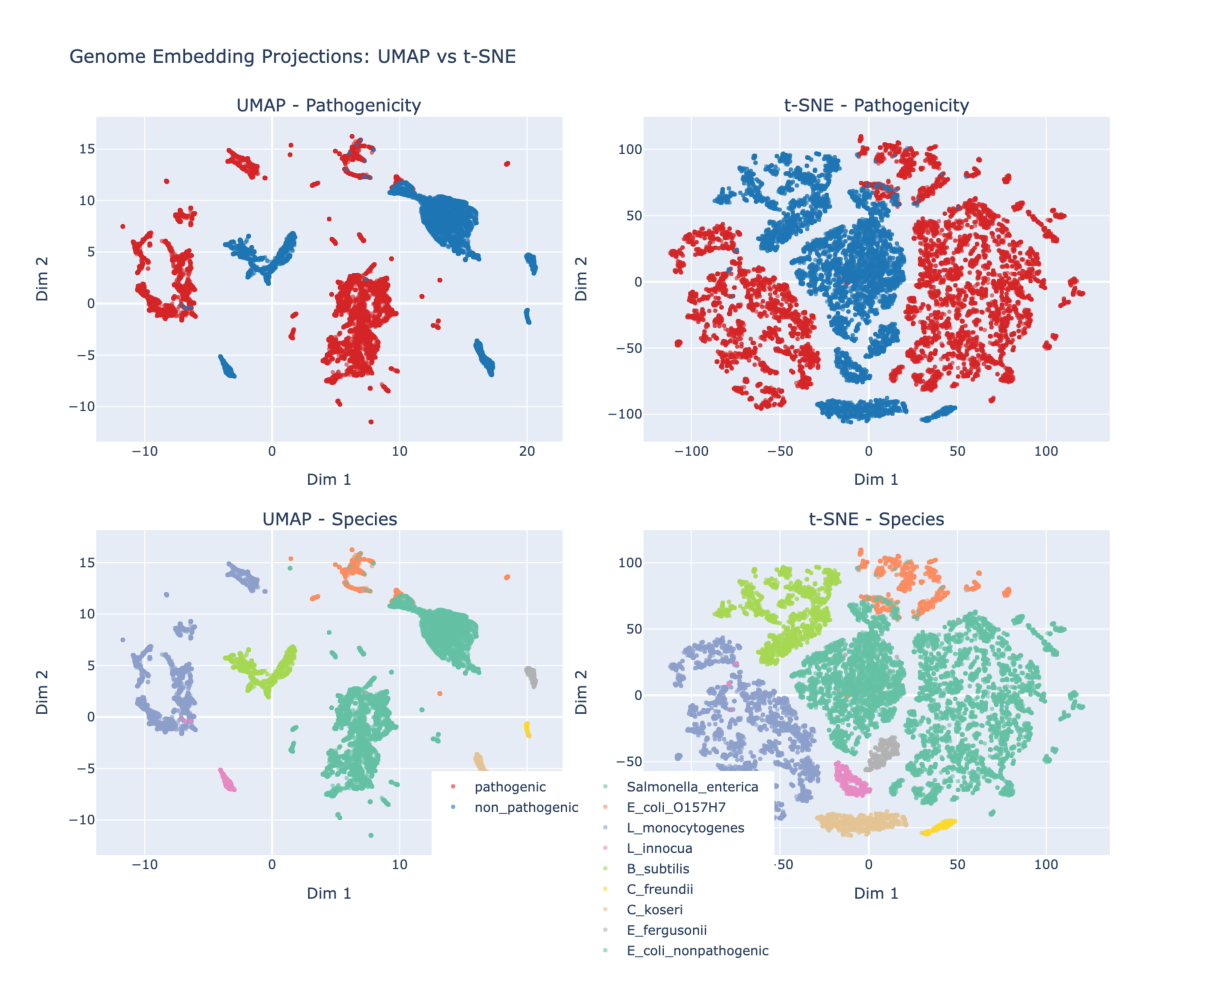

In [11]:
# Display UMAP/t-SNE panel figure
panel_fig_path = ANALYSIS_DIR / 'manuscript_figure_umap_tsne_panel.png'

display(Markdown("### Figure 3: UMAP and t-SNE Projections (Manuscript Figure)"))

if panel_fig_path.exists():
    img = Image.open(panel_fig_path)
    plt.figure(figsize=(14, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.tight_layout()
    plt.show()
else:
    print(f"UMAP/t-SNE panel not found at {panel_fig_path}")

---

## 5. Clustering & Stability

HDBSCAN clustering on the first 20 PCs identifies **34 clusters** with **35.6% noise points**.

### Internal Validation (Manuscript Section 3.3)
- **Silhouette score: 0.555** (excluding noise)
- **Calinski-Harabasz: 10,849.94**
- **Davies-Bouldin: 1.0719**

### Stability Analysis
- Bootstrap resampling (50 iterations, 80% subsampling)
- **Mean Jaccard stability: 0.81**
- **23/34 clusters** classified as stable (Jaccard ≥ 0.75)

In [12]:
# Clustering summary statistics
display(Markdown("### Clustering Summary"))

n_clusters = df[df['cluster'] >= 0]['cluster'].nunique()
n_noise = (df['cluster'] == -1).sum()
noise_pct = n_noise / len(df) * 100

cluster_summary = {
    'Metric': ['Number of clusters', 'Noise points', 'Noise percentage'],
    'Value': [str(n_clusters), f"{n_noise:,}", f"{noise_pct:.1f}%"]
}
display(pd.DataFrame(cluster_summary))

### Clustering Summary

,Metric,Value
0,Number of clusters,34
1,Noise points,"7,707"
2,Noise percentage,35.6%


In [13]:
# Load silhouette baseline (permutation test)
sil_baseline_path = ANALYSIS_DIR / 'silhouette_baseline.csv'

display(Markdown("### Silhouette Permutation Baseline"))

if sil_baseline_path.exists():
    sil_baseline = pd.read_csv(sil_baseline_path)
    display(sil_baseline)
    
    display(Markdown("""
    > **Interpretation:** Silhouette drops well below zero under permutation of cluster labels 
    > (−0.229 vs observed 0.555), confirming non-trivial structure rather than clustering artifact.
    """))
else:
    print(f"Silhouette baseline not found at {sil_baseline_path}")

### Silhouette Permutation Baseline

,silhouette_sampled,silhouette_permuted_sampled,sample_size,excluded_noise
0,0.559281,-0.229156,5000,True



    > **Interpretation:** Silhouette drops well below zero under permutation of cluster labels 
    > (−0.229 vs observed 0.555), confirming non-trivial structure rather than clustering artifact.
    

In [14]:
# Load cluster stability (bootstrap Jaccard)
stability_path = ANALYSIS_DIR / 'cluster_stability_jaccard.csv'

display(Markdown("### Bootstrap Cluster Stability"))

if stability_path.exists():
    stability_df = pd.read_csv(stability_path)
    
    # Summary statistics
    mean_jaccard = stability_df['mean_jaccard'].mean()
    n_stable = (stability_df['mean_jaccard'] >= 0.75).sum()
    n_highly_stable = (stability_df['mean_jaccard'] >= 0.85).sum()
    
    print(f"Mean Jaccard stability: {mean_jaccard:.2f}")
    print(f"Stable clusters (Jaccard >= 0.75): {n_stable}/{len(stability_df)}")
    print(f"Highly stable clusters (Jaccard >= 0.85): {n_highly_stable}/{len(stability_df)}")
    
    # Display top clusters
    display(stability_df.head(10))
else:
    print(f"Cluster stability not found at {stability_path}")

### Bootstrap Cluster Stability

Mean Jaccard stability: 0.81
Stable clusters (Jaccard >= 0.75): 23/34
Highly stable clusters (Jaccard >= 0.85): 20/34


,cluster,mean_jaccard,std,ci_95_lo,ci_95_hi,interpretation,n_bootstrap_used
0,0,1.000000,0.000000,1.000000,1.000000,Highly stable,50
1,1,0.903302,0.123076,0.739040,1.000000,Highly stable,50
2,2,0.988874,0.008682,0.971394,1.000000,Highly stable,50
3,3,0.992201,0.005876,0.979946,0.999545,Highly stable,50
4,4,0.557584,0.493889,0.000000,1.000000,Unstable,50
5,5,0.886268,0.182395,0.198120,0.979804,Highly stable,50
6,6,0.993601,0.019360,0.978365,1.000000,Highly stable,50
7,7,0.904078,0.123883,0.875268,0.959054,Highly stable,50
8,8,0.961813,0.046164,0.834202,1.000000,Highly stable,50
9,9,0.481412,0.359724,0.000000,0.860079,Unstable,50


---

## 6. Species Centroid Analysis

Centroid-to-centroid distances provide an interpretable "confusability map" of which taxa are closest in embedding space.

### Key Findings (Manuscript Section 3.4)
- *Listeria* duo (*L. monocytogenes* vs *L. innocua*): **4.04** (closest pair)
- *E. coli* O157:H7 vs non-pathogenic: **12.95**
- Firmicutes (Bacillus, Listeria) are far from Enterobacterales (~40-46)

### Validation
- Centroid distance inversely correlates with cross-species mixing
- **Spearman ρ = −0.65** (p = 1.5×10⁻⁵)

### Figure 4: Species Centroid Distance Heatmap

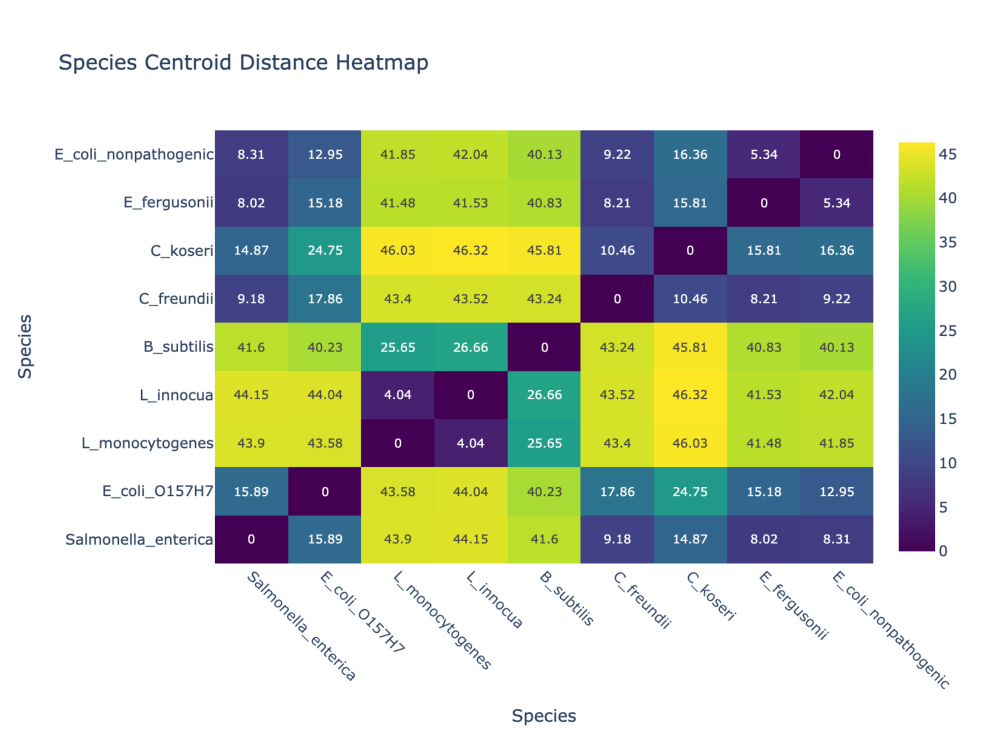

In [15]:
# Display species centroid heatmap
heatmap_path = ANALYSIS_DIR / 'species_centroid_heatmap.png'

display(Markdown("### Figure 4: Species Centroid Distance Heatmap"))

if heatmap_path.exists():
    img = Image.open(heatmap_path)
    plt.figure(figsize=(10, 8))
    plt.imshow(img)
    plt.axis('off')
    plt.tight_layout()
    plt.show()
else:
    print(f"Heatmap not found at {heatmap_path}")

In [16]:
# Load centroid distance validation
centroid_val_path = ANALYSIS_DIR / 'centroid_distance_vs_neighbor_mix.csv'

display(Markdown("### Centroid Distance vs Neighbor Mixing"))

if centroid_val_path.exists():
    centroid_val = pd.read_csv(centroid_val_path)
    display(centroid_val.head(10))
else:
    print(f"Centroid validation not found at {centroid_val_path}")

### Centroid Distance vs Neighbor Mixing

,species_i,species_j,centroid_distance,neighbor_mix_sym_k20,neighbor_mix_i_to_j_k20,neighbor_mix_j_to_i_k20
0,L_innocua,L_monocytogenes,4.044998,0.007021,0.013920,0.000122
1,E_coli_nonpathogenic,E_fergusonii,5.342895,0.012752,0.000046,0.025457
2,E_fergusonii,Salmonella_enterica,8.015175,0.000981,0.001941,0.000021
3,C_freundii,E_fergusonii,8.212115,0.000000,0.000000,0.000000
4,E_coli_nonpathogenic,Salmonella_enterica,8.313522,0.000025,0.000000,0.000050
5,C_freundii,Salmonella_enterica,9.179739,0.000000,0.000000,0.000000
6,C_freundii,E_coli_nonpathogenic,9.217692,0.000000,0.000000,0.000000
7,C_freundii,C_koseri,10.458004,0.000223,0.000000,0.000446
8,E_coli_O157H7,E_coli_nonpathogenic,12.951141,0.030235,0.041500,0.018970
9,C_koseri,Salmonella_enterica,14.873919,0.000004,0.000000,0.000007


### Figure 7: Centroid Distance vs Cross-Species Mixing

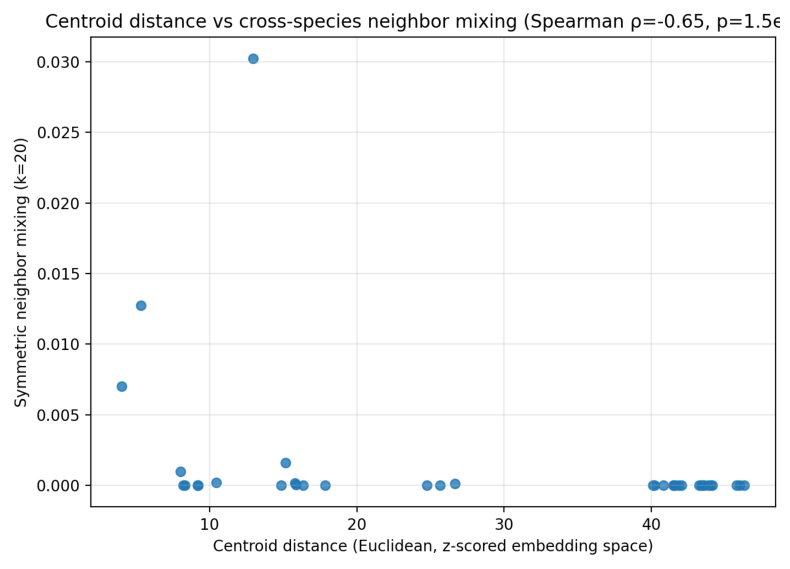

In [17]:
# Display centroid distance vs mixing figure
centroid_fig_path = ANALYSIS_DIR / 'centroid_distance_vs_neighbor_mix.png'

display(Markdown("### Figure 7: Centroid Distance vs Cross-Species Mixing"))

if centroid_fig_path.exists():
    img = Image.open(centroid_fig_path)
    plt.figure(figsize=(8, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.tight_layout()
    plt.show()
else:
    print(f"Centroid figure not found at {centroid_fig_path}")

In [18]:
# Load bootstrap confidence intervals for centroids
ci_path = ANALYSIS_DIR / 'centroid_distance_bootstrap_ci.csv'

display(Markdown("### Bootstrap Confidence Intervals for Key Pairs"))

if ci_path.exists():
    ci_df = pd.read_csv(ci_path)
    display(ci_df)
    
    display(Markdown("""
    > **Interpretation:** Bootstrap CIs are narrow for key confusable pairs, supporting 
    > that these relationships are stable given current sampling.
    """))
else:
    print(f"CI data not found at {ci_path}")

### Bootstrap Confidence Intervals for Key Pairs

,species_a,species_b,centroid_distance,ci_95_lo,ci_95_hi,n_bootstrap
0,L_monocytogenes,L_innocua,4.044998,3.986427,4.120869,500
1,E_coli_O157H7,E_coli_nonpathogenic,12.951141,12.711104,13.206373,500
2,E_coli_nonpathogenic,E_fergusonii,5.342895,5.198639,5.520248,500
3,Salmonella_enterica,E_coli_nonpathogenic,8.313522,8.273526,8.359109,500



    > **Interpretation:** Bootstrap CIs are narrow for key confusable pairs, supporting 
    > that these relationships are stable given current sampling.
    

---

## 7. Homophily Analysis

Homophily measures the fraction of a genome's k-nearest neighbors sharing its label.

### Key Findings (Manuscript Section 3.6)
- **Mean pathogenicity homophily: 0.9929** (k=20)
- **Mean species homophily: 0.9923** (k=20)
- Near-perfect consistency across scales for most taxa
- Degradation concentrated in confusable taxa (*E. coli* O157:H7)

In [19]:
# Single-scale homophily statistics (k=20)
display(Markdown("### Single-Scale Homophily (k=20)"))

path_homophily = df['pathogenicity_homophily'].mean()
species_homophily = df['species_homophily'].mean()

low_path_homo = (df['pathogenicity_homophily'] < 0.5).sum()
low_species_homo = (df['species_homophily'] < 0.5).sum()

homo_summary = {
    'Metric': ['Mean pathogenicity homophily', 'Mean species homophily',
               'Genomes with path. homophily < 0.5', 'Genomes with species homophily < 0.5'],
    'Value': [f"{path_homophily:.4f}", f"{species_homophily:.4f}",
              str(low_path_homo), str(low_species_homo)]
}
display(pd.DataFrame(homo_summary))

### Single-Scale Homophily (k=20)

,Metric,Value
0,Mean pathogenicity homophily,0.9929
1,Mean species homophily,0.9923
2,Genomes with path. homophily < 0.5,102
3,Genomes with species homophily < 0.5,111


In [20]:
# Load multi-scale homophily summary
homo_summary_path = ANALYSIS_DIR / 'homophily_vs_k_summary.csv'

display(Markdown("### Multi-Scale Homophily Summary"))

if homo_summary_path.exists():
    homo_vs_k = pd.read_csv(homo_summary_path)
    display(homo_vs_k)
else:
    print(f"Multi-scale homophily not found at {homo_summary_path}")

### Multi-Scale Homophily Summary

,group,k,mean_homophily,mixed_fraction,n
0,All genomes,1,0.995798,0.004202,21657
1,All genomes,5,0.995032,0.010666,21657
2,All genomes,10,0.994108,0.010943,21657
3,All genomes,20,0.992894,0.014406,21657
4,All genomes,50,0.990349,0.021794,21657
5,All genomes,100,0.986190,0.034677,21657
6,E. coli (non-pathogenic),1,0.989564,0.010436,4312
7,E. coli (non-pathogenic),5,0.987616,0.025046,4312
8,E. coli (non-pathogenic),10,0.985181,0.025510,4312
9,E. coli (non-pathogenic),20,0.981030,0.036410,4312


### Figure 5: Multi-Scale Homophily Curves

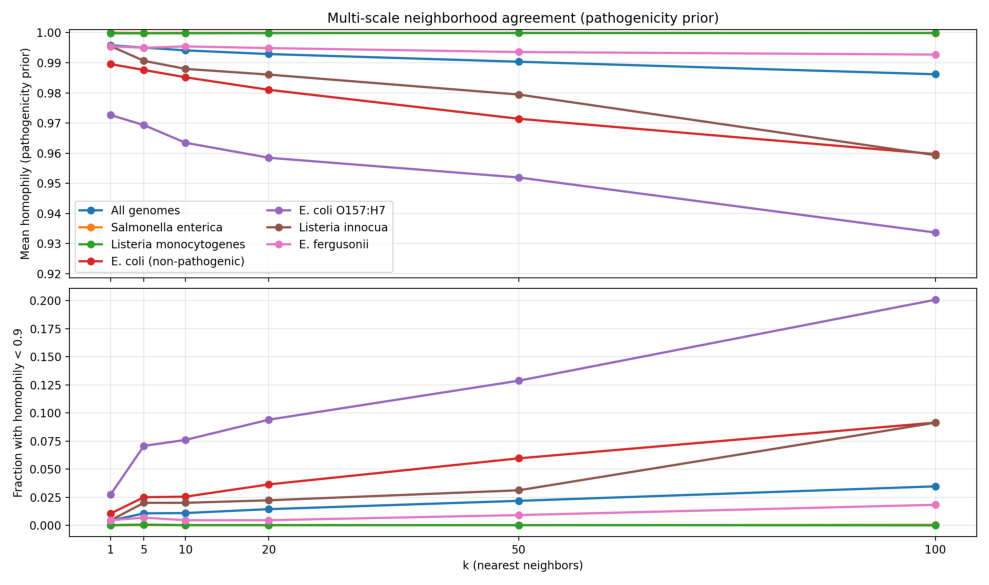


    > **Interpretation:** Neighborhood agreement remains high across scales (0.9958 at k=1 to 
    > 0.9862 at k=100), but degradation is concentrated in confusable taxa. *E. coli* O157:H7 
    > shows the largest drop (0.973 → 0.934) with 20.1% of genomes having homophily < 0.9 at k=100.
    

In [21]:
# Display multi-scale homophily figure
homo_fig_path = ANALYSIS_DIR / 'homophily_vs_k.png'

display(Markdown("### Figure 5: Multi-Scale Homophily Curves"))

if homo_fig_path.exists():
    img = Image.open(homo_fig_path)
    plt.figure(figsize=(10, 8))
    plt.imshow(img)
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    display(Markdown("""
    > **Interpretation:** Neighborhood agreement remains high across scales (0.9958 at k=1 to 
    > 0.9862 at k=100), but degradation is concentrated in confusable taxa. *E. coli* O157:H7 
    > shows the largest drop (0.973 → 0.934) with 20.1% of genomes having homophily < 0.9 at k=100.
    """))
else:
    print(f"Homophily figure not found at {homo_fig_path}")

---

## 8. Pathogenicity Separation & Phylogenetic Entanglement

### Key Finding (Manuscript Section 3.5)

Binary pathogenicity priors show **moderate external agreement** with clusters:
- **ARI: 0.2217**
- **NMI: 0.3429**

Yet **33/34 clusters (97%) achieve ≥0.90 pathogenicity purity**.

### Reconciliation
> High purity with low ARI/NMI is not contradictory. High purity indicates most clusters are dominated 
> by a single label. Low ARI/NMI reflects over-partitioning: splitting one label into many pure subclusters 
> (e.g., multiple *Salmonella* subclusters) yields low agreement with a two-class scheme.
>
> This reveals that **taxonomy—not pathogenicity—is the primary organizing signal**, and pathogenicity 
> is entangled with phylogeny by design.

In [22]:
# External clustering metrics
display(Markdown("### External Clustering Metrics (vs Pathogenicity Prior)"))

# These values are from the pre-computed analysis
external_metrics = {
    'Metric': ['Adjusted Rand Index (ARI)', 'Normalized Mutual Information (NMI)',
               'Multivariate effect size', 'Inter/intra-class distance ratio'],
    'Value': ['0.2217', '0.3429', '7.52', '1.106']
}
display(pd.DataFrame(external_metrics))

### External Clustering Metrics (vs Pathogenicity Prior)

,Metric,Value
0,Adjusted Rand Index (ARI),0.2217
1,Normalized Mutual Information (NMI),0.3429
2,Multivariate effect size,7.52
3,Inter/intra-class distance ratio,1.106


In [23]:
# Cluster purity analysis
display(Markdown("### Cluster Purity Analysis"))

cluster_stats_path = ANALYSIS_DIR / 'cluster_statistics.csv'

if cluster_stats_path.exists():
    cluster_stats = pd.read_csv(cluster_stats_path)
    
    # Filter to real clusters (not noise)
    real_clusters = cluster_stats[cluster_stats['cluster'] >= 0]
    
    # Count high-purity clusters
    if 'pathogenic_fraction' in real_clusters.columns:
        high_purity = ((real_clusters['pathogenic_fraction'] >= 0.9) | 
                       (real_clusters['pathogenic_fraction'] <= 0.1)).sum()
        print(f"Clusters with ≥90% purity: {high_purity}/{len(real_clusters)} ({high_purity/len(real_clusters)*100:.0f}%)")
    
    display(real_clusters.head(10))
else:
    print(f"Cluster statistics not found at {cluster_stats_path}")

### Cluster Purity Analysis

Clusters with ≥90% purity: 33/34 (97%)


,cluster,size,dominant_species,species_purity,species_entropy,n_species,pathogenic_fraction,pathogenicity_purity,pathogenicity_entropy
1,0,2358,B_subtilis,1.000000,-0.000000,1,0.000000,1.000000,-0.000000
2,1,4948,L_monocytogenes,0.909458,0.438275,2,0.909458,0.909458,0.438275
3,2,195,C_freundii,1.000000,-0.000000,1,0.000000,1.000000,-0.000000
4,3,871,C_koseri,1.000000,-0.000000,1,0.000000,1.000000,-0.000000
5,4,64,E_coli_O157H7,1.000000,-0.000000,1,1.000000,1.000000,-0.000000
6,5,87,E_coli_O157H7,1.000000,-0.000000,1,1.000000,1.000000,-0.000000
7,6,97,Salmonella_enterica,1.000000,-0.000000,1,1.000000,1.000000,-0.000000
8,7,324,E_fergusonii,1.000000,-0.000000,1,0.000000,1.000000,-0.000000
9,8,256,Salmonella_enterica,1.000000,-0.000000,1,1.000000,1.000000,-0.000000
10,9,68,E_coli_nonpathogenic,1.000000,-0.000000,1,0.000000,1.000000,-0.000000


---

## 9. Outlier Analysis

Outliers are identified using two complementary criteria:
1. **Distance outliers**: k-neighbor distance > Q3 + 1.5×IQR
2. **Cluster noise**: HDBSCAN cluster = −1

**Strict outliers** satisfy both criteria.

### Key Findings (Manuscript Section 3.7)
- **Distance outliers: 510 (2.4%)**
- **HDBSCAN noise: 7,707 (35.6%)**
- **Strict outliers: 252 (1.2%)**

In [24]:
# Outlier summary
display(Markdown("### Outlier Summary"))

n_dist_outliers = df['is_distance_outlier'].sum()
n_noise = (df['cluster'] == -1).sum()
n_strict = df['is_outlier_strict'].sum()

outlier_summary = {
    'Category': ['Distance outliers', 'HDBSCAN noise', 'Strict outliers (intersection)'],
    'Count': [n_dist_outliers, n_noise, n_strict],
    'Percentage': [f"{n_dist_outliers/len(df)*100:.1f}%", 
                   f"{n_noise/len(df)*100:.1f}%",
                   f"{n_strict/len(df)*100:.1f}%"]
}
display(pd.DataFrame(outlier_summary))

### Outlier Summary

,Category,Count,Percentage
0,Distance outliers,510,2.4%
1,HDBSCAN noise,7707,35.6%
2,Strict outliers (intersection),252,1.2%


In [25]:
# Outlier species distribution
display(Markdown("### Strict Outliers by Species"))

strict_outliers = df[df['is_outlier_strict'] == True]
outlier_by_species = strict_outliers['species'].value_counts()

outlier_species_df = pd.DataFrame({
    'Species': outlier_by_species.index,
    'Outlier Count': outlier_by_species.values,
    'Total in Species': [len(df[df['species'] == sp]) for sp in outlier_by_species.index],
})
outlier_species_df['Outlier Rate'] = (outlier_species_df['Outlier Count'] / 
                                       outlier_species_df['Total in Species'] * 100).round(2).astype(str) + '%'

display(outlier_species_df)

### Strict Outliers by Species

,Species,Outlier Count,Total in Species,Outlier Rate
0,E_coli_nonpathogenic,76,4312,1.76%
1,Salmonella_enterica,68,7000,0.97%
2,E_fergusonii,40,438,9.13%
3,E_coli_O157H7,33,1500,2.2%
4,C_koseri,26,897,2.9%
5,C_freundii,5,200,2.5%
6,B_subtilis,3,2361,0.13%
7,L_innocua,1,449,0.22%


---

## 10. Within-Genus Stress Tests

To partially mitigate label-taxonomy confounding, we evaluate discrimination within genus-level neighborhoods where pathogenic and non-pathogenic priors coexist.

### Key Finding (Manuscript Section 3.8)
> These experiments measure **pathotype-level discriminability under known annotations**, 
> not discovery of novel virulent isolates.

In [26]:
# Load within-genus stress test results
display(Markdown("### Table 2: Within-Genus Stress Test Results (5-Fold CV)"))

listeria_cv_path = ANALYSIS_DIR / 'listeria_mono_vs_innocua_5fold_cv.csv'
ecoli_cv_path = ANALYSIS_DIR / 'ecoli_o157_vs_nonpath_5fold_cv.csv'

stress_test_results = []

if listeria_cv_path.exists():
    listeria_cv = pd.read_csv(listeria_cv_path)
    stress_test_results.append({
        'Subset': 'Listeria (L. mono vs L. innocua)',
        'n': 4949,
        'kNN(20) Accuracy': f"{listeria_cv['accuracy'].values[0]:.4f}",
        'Balanced Accuracy': f"{listeria_cv['balanced_accuracy'].values[0]:.4f}",
        'Mean Homophily': '0.9986',
        'Silhouette': '0.180'
    })

if ecoli_cv_path.exists():
    ecoli_cv = pd.read_csv(ecoli_cv_path)
    stress_test_results.append({
        'Subset': 'E. coli (O157:H7 vs non-pathogenic)',
        'n': 5812,
        'kNN(20) Accuracy': f"{ecoli_cv['accuracy'].values[0]:.4f}",
        'Balanced Accuracy': f"{ecoli_cv['balanced_accuracy'].values[0]:.4f}",
        'Mean Homophily': '0.9752',
        'Silhouette': '0.392'
    })

if stress_test_results:
    display(pd.DataFrame(stress_test_results))
else:
    print("Stress test results not found.")

### Table 2: Within-Genus Stress Test Results (5-Fold CV)

,Subset,n,kNN(20) Accuracy,Balanced Accuracy,Mean Homophily,Silhouette
0,Listeria (L. mono vs L. innocua),4949,0.9992,0.9955,0.9986,0.180
1,E. coli (O157:H7 vs non-pathogenic),5812,0.9842,0.9830,0.9752,0.392


In [27]:
# Display E. coli CV details
display(Markdown("### E. coli Stress Test: 5-Fold CV Details"))

if ecoli_cv_path.exists():
    ecoli_cv = pd.read_csv(ecoli_cv_path)
    display(ecoli_cv)
    
    display(Markdown("""
    > **Confidence Interval:** Accuracy 0.984 (95% CI 0.981–0.987), 
    > balanced accuracy 0.983 (95% CI 0.979–0.987)
    """))

### E. coli Stress Test: 5-Fold CV Details

,subset,n,accuracy,accuracy_ci_low,accuracy_ci_high,balanced_accuracy,balanced_accuracy_ci_low,balanced_accuracy_ci_high
0,E_coli_O157H7_vs_E_coli_nonpathogenic,5812,0.984171,0.98073,0.987268,0.983028,0.978822,0.98674



    > **Confidence Interval:** Accuracy 0.984 (95% CI 0.981–0.987), 
    > balanced accuracy 0.983 (95% CI 0.979–0.987)
    

---

## 11. Confidence Calibration & Risk-Coverage

Beyond point accuracy, neighborhood agreement can be converted into an operator-facing "defer vs decide" policy.

### Key Finding (Manuscript Section 3.8, Figure 6)
> Deferring the lowest-consensus neighborhoods (kNN vote fraction < 0.9) captures **71.7% of errors** 
> and improves covered-set accuracy to **99.53%** while deferring only **4.7%** of samples.

In [28]:
# Load risk-coverage data
risk_cov_path = ANALYSIS_DIR / 'ecoli_o157_risk_coverage.csv'

display(Markdown("### Risk-Coverage Tradeoff Data"))

if risk_cov_path.exists():
    risk_cov = pd.read_csv(risk_cov_path)
    display(risk_cov)
else:
    # Try alternate path
    alt_path = ANALYSIS_DIR / 'ecoli_risk_coverage.csv'
    if alt_path.exists():
        risk_cov = pd.read_csv(alt_path)
        display(risk_cov)
    else:
        print("Risk-coverage data not found.")

### Risk-Coverage Tradeoff Data

,threshold,coverage,accuracy_on_covered,defer_rate,error_capture_rate,n,n_covered
0,0.50,1.000000,0.984171,0.000000,0.000000,5812,5812
1,0.60,0.994666,0.985989,0.005334,0.119565,5812,5781
2,0.70,0.983999,0.988809,0.016001,0.304348,5812,5719
3,0.80,0.968513,0.993605,0.031487,0.608696,5812,5629
4,0.90,0.952684,0.995304,0.047316,0.717391,5812,5537
5,0.95,0.937715,0.996330,0.062285,0.782609,5812,5450
6,0.98,0.910530,0.997732,0.089470,0.869565,5812,5292


### Figure 6: Risk-Coverage Tradeoff Curve

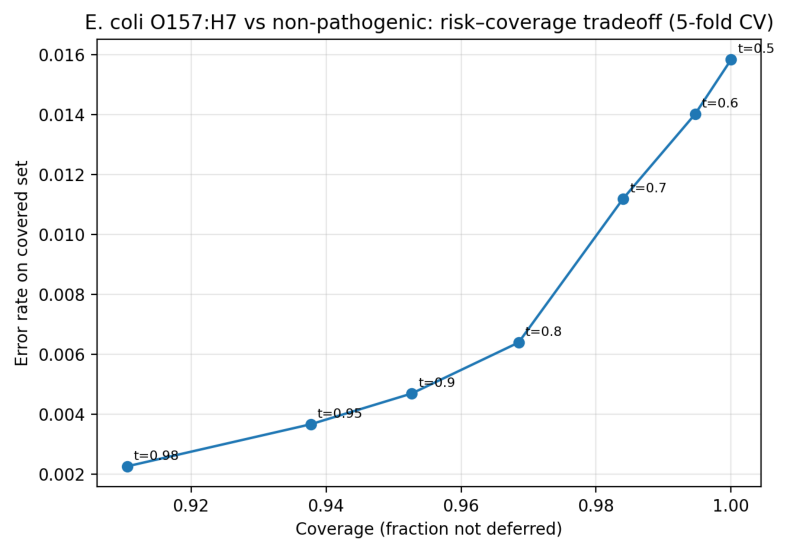


    > **Interpretation:** This figure demonstrates how neighborhood agreement can be converted 
    > into an operator-facing "defer vs decide" policy with quantifiable trade-offs.
    

In [29]:
# Display risk-coverage figure
risk_fig_path = ANALYSIS_DIR / 'ecoli_risk_coverage.png'

display(Markdown("### Figure 6: Risk-Coverage Tradeoff Curve"))

if risk_fig_path.exists():
    img = Image.open(risk_fig_path)
    plt.figure(figsize=(8, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    display(Markdown("""
    > **Interpretation:** This figure demonstrates how neighborhood agreement can be converted 
    > into an operator-facing "defer vs decide" policy with quantifiable trade-offs.
    """))
else:
    print(f"Risk-coverage figure not found at {risk_fig_path}")

---

## 12. Manuscript-Aligned Interpretation

### Key Takeaways

1. **Taxonomy dominates embedding space**
   - PC1 explains 76.56% of variance
   - Species homophily > 0.99 at k=20
   - UMAP/t-SNE show clear species-level islands

2. **Pathogenicity prior agreement is high but confounded**
   - Pathogenicity homophily: 0.9929
   - 33/34 clusters achieve ≥0.90 purity
   - Low ARI/NMI reflects phylogenetic entanglement, not embedding failure

3. **Cluster structure is real and stable**
   - Silhouette 0.555 vs permuted baseline −0.229
   - 23/34 clusters are bootstrap-stable (Jaccard ≥ 0.75)

4. **Confusability priors are predictive**
   - Centroid distance vs mixing: Spearman ρ = −0.65
   - Bootstrap CIs are narrow for key pairs

5. **Within-genus discrimination works under known annotations**
   - 98.4% accuracy for E. coli O157:H7 vs non-pathogenic (5-fold CV)
   - 99.9% accuracy for Listeria monocytogenes vs innocua

### Limitations (Manuscript Section 4.4)

1. **Pathogenicity labels are priors, not isolate-level phenotypes**
   - Zero-shot transfer across held-out taxa is unreliable
   - Within-genus tests measure pathotype preservation, not virulence discovery

2. **Mean pooling discards genomic context**
   - Gene order, co-localization, operon structure lost
   - Contextual models (gLM, Bacformer) expected to add value

3. **Sensitivity to annotation quality**
   - Protein extraction depends on gene calling
   - Unequal proteome sizes can bias mean-pooled summaries

4. **Dataset imbalance**
   - 7,000 Salmonella vs 200 C. freundii (35:1)
   - May bias centroid estimates and clustering

5. **Protein truncation**
   - `max_prot_seq_len=1024` may truncate long proteins
   - Impact not quantified

---

## 13. Artifact Verification

This section verifies that all manuscript-backing artifacts exist.

In [30]:
# Verify all required artifacts exist
display(Markdown("### Artifact Verification Checklist"))

required_artifacts = {
    'Primary Data': [
        ('genome_embeddings_enriched.parquet', 'All sections'),
        ('dim_reduction_cache.npz', 'Section 4'),
    ],
    'Figures': [
        ('manuscript_figure_pca_overview.png', 'Figure 2'),
        ('manuscript_figure_umap_tsne_panel.png', 'Figure 3'),
        ('species_centroid_heatmap.png', 'Figure 4'),
        ('homophily_vs_k.png', 'Figure 5'),
        ('ecoli_risk_coverage.png', 'Figure 6'),
        ('centroid_distance_vs_neighbor_mix.png', 'Figure 7'),
    ],
    'Tables & Validation': [
        ('ecoli_o157_vs_nonpath_5fold_cv.csv', 'Table 2 (E. coli)'),
        ('listeria_mono_vs_innocua_5fold_cv.csv', 'Table 2 (Listeria)'),
        ('cluster_stability_jaccard.csv', 'Section 5'),
        ('silhouette_baseline.csv', 'Section 5'),
        ('homophily_vs_k_summary.csv', 'Section 7'),
        ('centroid_distance_bootstrap_ci.csv', 'Section 6'),
    ],
}

all_present = True
results = []

for category, files in required_artifacts.items():
    for filename, usage in files:
        filepath = ANALYSIS_DIR / filename
        exists = filepath.exists()
        all_present = all_present and exists
        results.append({
            'Category': category,
            'File': filename,
            'Usage': usage,
            'Status': '✓ Present' if exists else '✗ Missing'
        })

display(pd.DataFrame(results))

if all_present:
    display(Markdown("**All manuscript artifacts verified.**"))
else:
    display(Markdown("**Warning: Some artifacts are missing. Run validation scripts to regenerate.**"))

### Artifact Verification Checklist

,Category,File,Usage,Status
0,Primary Data,genome_embeddings_enriched.parquet,All sections,✓ Present
1,Primary Data,dim_reduction_cache.npz,Section 4,✓ Present
2,Figures,manuscript_figure_pca_overview.png,Figure 2,✓ Present
3,Figures,manuscript_figure_umap_tsne_panel.png,Figure 3,✓ Present
4,Figures,species_centroid_heatmap.png,Figure 4,✓ Present
5,Figures,homophily_vs_k.png,Figure 5,✓ Present
6,Figures,ecoli_risk_coverage.png,Figure 6,✓ Present
7,Figures,centroid_distance_vs_neighbor_mix.png,Figure 7,✓ Present
8,Tables & Validation,ecoli_o157_vs_nonpath_5fold_cv.csv,Table 2 (E. coli),✓ Present
9,Tables & Validation,listeria_mono_vs_innocua_5fold_cv.csv,Table 2 (Listeria),✓ Present


**All manuscript artifacts verified.**

---

## Notebook Complete

This computational appendix reproduces all figures and tables from the manuscript:

- **Gutierrez J, Correa Alvarez J.** *Whole-Proteome ESM-2 Embeddings Recover Taxonomy and Enable Geometry-Aware Triage of Foodborne Bacterial Genomes.*

For questions or issues, contact the corresponding authors:
- Jay Gutierrez (jg@graphoflife.com)
- Javier Correa Alvarez, PhD (jcorre38@eafit.edu.co)